<a href="https://colab.research.google.com/github/mphute/Recommender-systems/blob/main/sdpv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.1

In [147]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [148]:
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
# interactive visualization

  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-2l4fe2q6
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-2l4fe2q6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-cp36-none-any.whl size=730030 sha256=b205531ccf68b95f5e463fcd127b1431c41834ffef36573902ba6d3bd416c110
  Stored in directory: /tmp/pip-ephem-wheel-cache-gil1hbp0/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair


RendererRegistry.enable('colab')

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [150]:
%cd drive/My Drive/


[Errno 2] No such file or directory: 'drive/My Drive/'
/content/drive/My Drive


In [151]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'Movielens/ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'Movielens/ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'Movielens/ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0. This will make handling of the
# indices easier later
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [152]:
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [153]:

movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995,Animation,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995,Action,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995,Crime,Crime-Drama-Thriller


In [154]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [155]:
def split_dataframe(df, holdout_fraction=0.2):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [156]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [157]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [158]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores


In [159]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def loss(self):
      return self._loss

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          #tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [160]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_movies.head()

,user_id,movie_id
0,0,"[60, 188, 32, 159, 19, 201, 170, 264, 154, 116..."
1,1,"[291, 250, 49, 313, 296, 289, 311, 280, 12, 27..."
2,10,"[110, 557, 731, 226, 424, 739, 722, 37, 724, 1..."
3,100,"[828, 303, 595, 221, 470, 404, 280, 251, 281, ..."
4,101,"[767, 822, 69, 514, 523, 321, 624, 160, 447, 4..."


In [161]:
#@title Batch generation code (run this cell)
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}
genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  movie = []
  year = []
  genre = []
  label = []
  for movie_ids in ratings["movie_id"].values:
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    label.append([int(movie_id) for movie_id in movie_ids])
  features = {
      "movie_id": pad(movie, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

In [162]:
#Solution
def softmax_loss(user_embeddings, movie_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    movie_embeddings: A tensor of shape [num_movies, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = movie_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))

  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss


In [163]:

def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [164]:
def movie_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')

In [165]:

def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
  """Builds a Softmax model for MovieLens.
  Args:
    rated_movies: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
  train_batch = make_batch(train_rated_movies, 200)
  test_batch = make_batch(test_rated_movies, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, movie_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, movie_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"movie_id": movie_embeddings}
  return CFModel(embeddings, train_loss, metrics)

 iteration 10: train_loss=7.425667, test_loss=7.424627, test_precision_at_10=0.001182

FailedPreconditionError: ignored

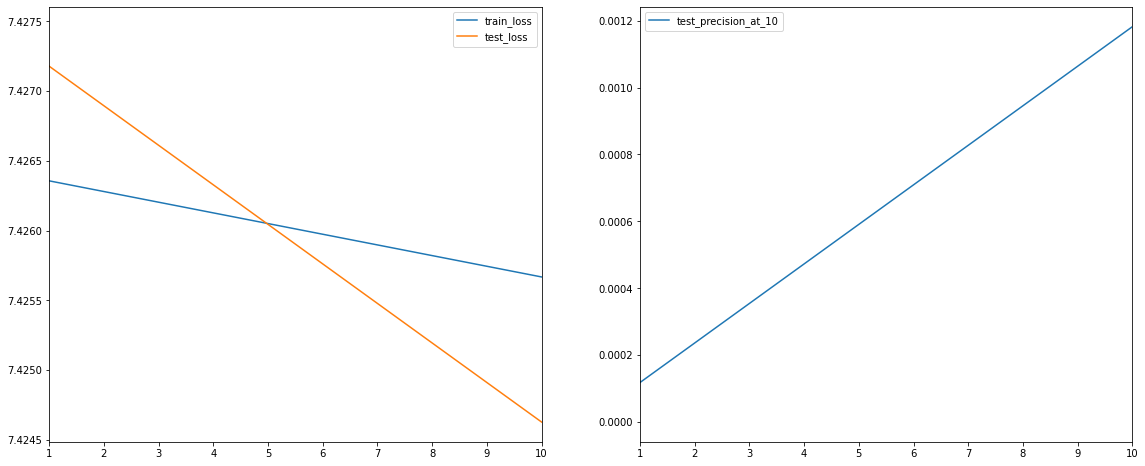

In [181]:
#Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')
g = tf.Graph()
with g.as_default():
  softmax_model = build_softmax_model(
      rated_movies,
      embedding_cols=[
          make_embedding_col("movie_id", 35),
          make_embedding_col("genre", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])
  saver = tf.train.Saver()
  softmax_model.train(
    learning_rate=8., num_iterations=10, optimizer=tf.train.AdagradOptimizer) # num iter = 3000 
  init_op = tf.initialize_all_variables()

  with tf.Session(graph=g) as sess:
    sess.run(init_op)
    sf2loss = softmax_model.loss()
    print(sf2loss.eval(session = sess))



#### create a checkpoint!!!     


In [179]:
init_op = tf.initialize_all_variables()

with tf.Session(graph=g) as sess:
  sess.run(init_op)
  sf2loss = softmax_model.loss()
  print(sf2loss.eval(session = sess))


ValueError: ignored

In [ ]:
movie_neighbors(softmax_model, "GoldenEye", DOT)
movie_neighbors(softmax_model, "GoldenEye", COSINE)

In [23]:
movie_embedding_norm(softmax_model)

alt.HConcatChart(...)

In [24]:
tsne_movie_embeddings(softmax_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.137s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.190020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.351597
[t-SNE] KL divergence after 400 iterations: 1.246618


alt.HConcatChart(...)

In [142]:
type(softmax_model.embeddings["movie_id"])
sfloss = softmax_model.loss
sf2loss = sfloss()


In [42]:
#df.to_csv()   # save all columns except coordinates to a csv file
np.save('movie_embeddings.npy', softmax_model.embeddings["movie_id"])

In [44]:
x = np.load('movie_embeddings.npy')

In [54]:
len(x[0])

35

In [47]:
emb2 = dict()
emb2['movie_id'] = x

In [74]:
soft2model = CFModel(emb2,sf2loss)
soft2model

In [77]:
soft2model.embeddings['movie_id'] = x

In [78]:
movie_neighbors(soft2model, "GoldenEye", COSINE)

Nearest neighbors of : GoldenEye (1995).


,cosine score,titles,genres
1,1.000,GoldenEye (1995),Action-Adventure-Thriller
230,0.941,Batman Returns (1992),Action-Adventure-Comedy-Crime
67,0.922,"Crow, The (1994)",Action-Romance-Thriller
28,0.908,Batman Forever (1995),Action-Adventure-Comedy-Crime
549,0.883,Die Hard: With a Vengeance (1995),Action-Thriller
225,0.876,Die Hard 2 (1990),Action-Thriller
